In [6]:
from rul_pm.dataset.CMAPSS import CMAPSSDataset, sensor_indices
from rul_pm.transformation.transformers import Transformer, transformation_pipeline, numericals_pipeline
from rul_pm.models.keras import  KerasTrainableModel
from rul_pm.models.keras.losses import root_mean_squared_error
from rul_pm.models.keras.XiangQiangJianQiao import XiangQiangJianQiaoModel
from rul_pm.models.keras.losses import weighted_categorical_crossentropy
from rul_pm.models.keras.attention import Attention
from rul_pm.transformation.utils import PandasTransformerWrapper
from rul_pm.graphics.plots import plot_errors_wrt_RUL
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from rul_pm.iterators.batcher import get_batcher, dataset_map, get_features
from tensorflow.keras import backend as K, Model, Input, optimizers
import seaborn
seaborn.set()

In [7]:
from tensorflow.keras.layers import TimeDistributed 
from tensorflow.keras.layers import (Layer, Conv1D, Dense, Add, Input, AveragePooling1D,
                                     BatchNormalization, LayerNormalization, Flatten,
                                     Concatenate, Bidirectional, Conv2D, MaxPooling1D,
                                     Permute, TimeDistributed, Multiply, LeakyReLU,    
                                     GlobalAveragePooling1D, MaxPooling2D,
                                     Softmax, AveragePooling2D,
                                     ConvLSTM2D ,SpatialDropout2D, LocallyConnected1D,
                                     multiply, concatenate, Activation, Masking,
                                     Masking, LSTM, GRU, MaxPool1D, Conv1D, Dropout, Average,
                                     Reshape, UpSampling1D, AveragePooling1D,GaussianNoise,
                                     Concatenate, Bidirectional)
from tcn import TCN
from tensorflow.keras import backend as K, Model, Input, optimizers
import tensorflow as tf

In [8]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
test_dataset = CMAPSSDataset(train=False, model='FD001')

In [9]:
sensors = ['SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']

useful_sensors = [sensors[i-1] for i in sensor_indices]

# 1. Remaining useful life estimation in prognostics using deep convolution neural networks
Author 
* Xiang Li
* Qian Ding
* Jian-Qiao Sunc

https://www.sciencedirect.com/science/article/pii/S0951832017307779?casa_token=DHKuBa83HrcAAAAA:-U6kHeTYyqmo9XYB8Wm-hOFOx-2IMOC_o5bhZEpdEW8tTB8zliBx9kzxiFuqX6pu_lf7nAQDqeq-#tbl0002


A deep learning method for prognostics is proposed based on convolution neural networks. Dropout technique is employed to relieve overfitting problem. Experiments are carried out on the popular C-MAPSS dataset to show the effectiveness of the proposed method. The goal of the task is to estimate the remaining useful life of aero-engine units accurately. With raw feature selection, data pre-processing and sample preparation using time window, good prognostic performance is achieved with the proposed method, and small error between the prediction and the actual RUL value is obtained for the testing data. The RUL in the life-time of the engine units can be well predicted, especially for the late period close to failure.


In [11]:
from rul_pm.transformation.target import PicewiseRULThreshold
transformer = Transformer(
                'RUL',
                transformation_pipeline(                                
                    numericals_pipeline(
                        scaler=PandasTransformerWrapper(MinMaxScaler((-1, 1))),
                        numerical_features=useful_sensors
                    )
                ),
                transformerY = Pipeline(steps=[
                    ('picewise', PicewiseRULThreshold(125))
                ])
            )



In [12]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=0)) 
    
def scheduler(epoch, lr): 
    if epoch < 200:
        return 0.001
    else:
        return 0.0001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model = XiangQiangJianQiaoModel(
            10,
            10,           
            dropout=0.5,
            window=30,
            batch_size=512,
            step = 1,
            transformer=transformer,
            shuffle='all',
            models_path=Path('.'),
            patience=15,
            cache_size=120,
            callbacks=[lr_callback],
            learning_rate=1e-3,
            loss=root_mean_squared_error)

In [13]:
model.fit(train_dataset, test_dataset, epochs=100)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 14)]          0         
_________________________________________________________________
lambda (Lambda)              (None, 30, 14, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 14, 10)        110       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 14, 10)        1010      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 14, 1)         31   


Epoch 1/100
35/35 [==============================] - 8s 198ms/step - loss: 84.9940 - root_mean_squared_error: 75.1990 - val_loss: 93.0960 - val_root_mean_squared_error: 88.7044
Epoch 2/100
35/35 [==============================] - 7s 199ms/step - loss: 76.5106 - root_mean_squared_error: 65.6917 - val_loss: 89.6999 - val_root_mean_squared_error: 85.1265
Epoch 3/100
35/35 [==============================] - 7s 201ms/step - loss: 73.5466 - root_mean_squared_error: 62.7183 - val_loss: 86.3997 - val_root_mean_squared_error: 81.7098
Epoch 4/100
35/35 [==============================] - 7s 202ms/step - loss: 70.7253 - root_mean_squared_error: 60.0225 - val_loss: 83.1634 - val_root_mean_squared_error: 78.3842
Epoch 5/100
35/35 [==============================] - 7s 201ms/step - loss: 67.7009 - root_mean_squared_error: 57.0648 - val_loss: 79.9919 - val_root_mean_squared_error: 75.1517
Epoch 6/100
35/35 [==============================] - 7s 200ms/step - loss: 65.1397 - root_mean_squared_error: 54.7

35/35 [==============================] - 7s 196ms/step - loss: 14.7149 - root_mean_squared_error: 11.6907 - val_loss: 15.8991 - val_root_mean_squared_error: 13.4192
Epoch 48/100
35/35 [==============================] - 7s 200ms/step - loss: 14.7433 - root_mean_squared_error: 11.7199 - val_loss: 14.4901 - val_root_mean_squared_error: 12.3390
Epoch 49/100
35/35 [==============================] - 7s 194ms/step - loss: 14.6301 - root_mean_squared_error: 11.5994 - val_loss: 14.5349 - val_root_mean_squared_error: 12.2426
Epoch 50/100
35/35 [==============================] - 7s 194ms/step - loss: 14.3456 - root_mean_squared_error: 11.3619 - val_loss: 14.4855 - val_root_mean_squared_error: 12.1304
Epoch 51/100
35/35 [==============================] - 7s 194ms/step - loss: 14.3866 - root_mean_squared_error: 11.3357 - val_loss: 14.2774 - val_root_mean_squared_error: 11.8814
Epoch 52/100
35/35 [==============================] - 7s 193ms/step - loss: 14.4731 - root_mean_squared_error: 11.3625 - va

{'parameters': {'window': 30,
  'batch_size': 512,
  'step': 1,
  'shuffle': 'all',
  'patience': 15,
  'transformer': {'target_column': ['RUL'],
   'features': None,
   'transformerX': [('resampler',
     [('selector',
       {'features': ['SensorMeasure2',
         'SensorMeasure3',
         'SensorMeasure4',
         'SensorMeasure7',
         'SensorMeasure8',
         'SensorMeasure9',
         'SensorMeasure11',
         'SensorMeasure12',
         'SensorMeasure13',
         'SensorMeasure14',
         'SensorMeasure15',
         'SensorMeasure17',
         'SensorMeasure20',
         'SensorMeasure21'],
        'features_indices': None,
        'features_computed_': ['SensorMeasure11',
         'SensorMeasure12',
         'SensorMeasure13',
         'SensorMeasure14',
         'SensorMeasure15',
         'SensorMeasure17',
         'SensorMeasure2',
         'SensorMeasure20',
         'SensorMeasure21',
         'SensorMeasure3',
         'SensorMeasure4',
         'SensorMeas

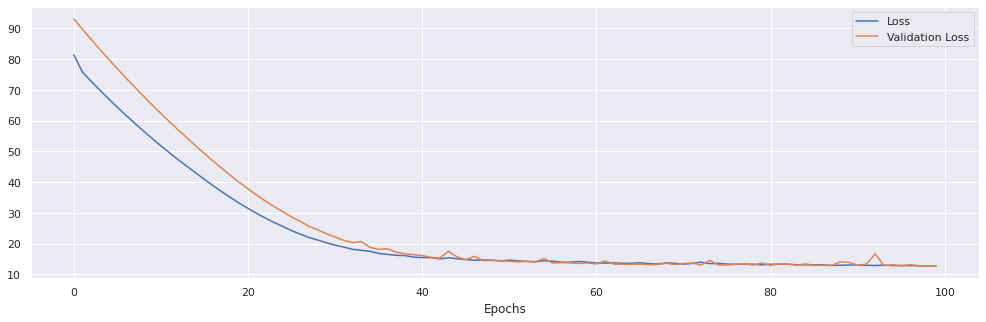

In [14]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.history.history['loss'], label='Loss')
ax.plot(model.history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()

# 1.1 Training set results

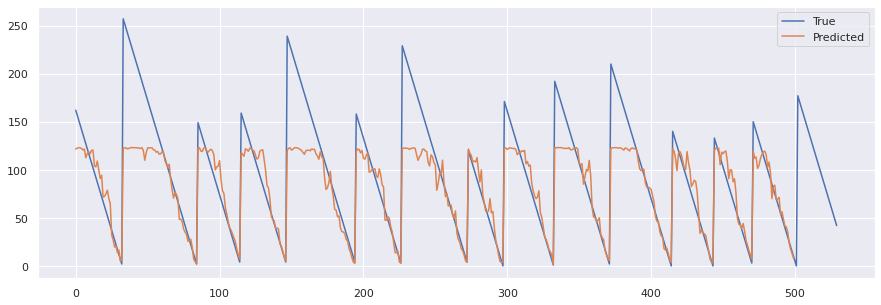

In [15]:
v = model.predict(train_dataset, step=5)
pred_cont = v
true_data = get_features(train_dataset, step=5, window=30, features=['RUL'])
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(true_data['RUL'][0:530], label='True')
ax.plot(pred_cont[0:500], label='Predicted')
ax.legend()

(<Figure size 1800x504 with 1 Axes>, <AxesSubplot:xlabel='RUL', ylabel='RMSE'>)

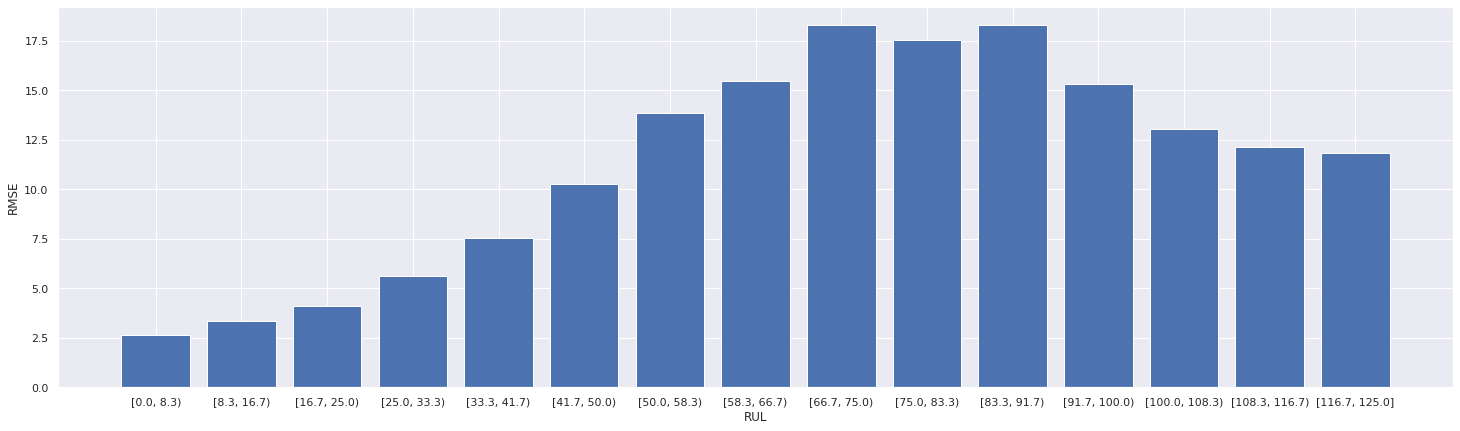

In [16]:
val_rul = np.array(true_data['RUL'])
pred_cont = np.squeeze(pred_cont)
plot_errors_wrt_RUL(val_rul, pred_cont, 125, 15, figsize=(25, 7))

## 1.1 Test set results

In [17]:

v = model.predict(test_dataset, step=1)
#predicted_probas = v
#idx_tensor = transformer.transformerY['scale'].value_ranges[:-1]
#pred_cont = np.sum(predicted_probas * idx_tensor, axis=1)
pred_cont = v
true_data = get_features(test_dataset, step=1, window=30, features=['RUL'])

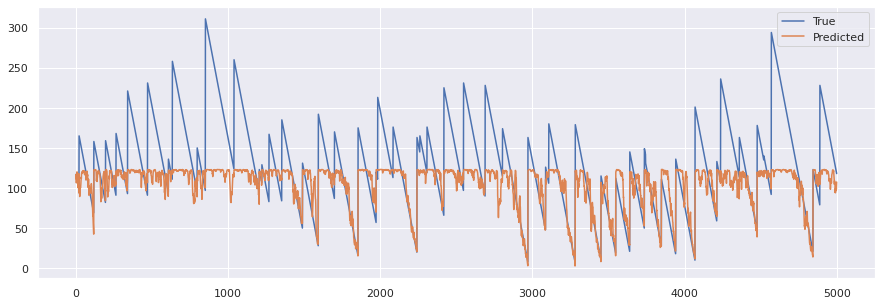

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(true_data['RUL'][0:5000], label='True')
ax.plot(pred_cont[0:5000], label='Predicted')
ax.legend()

(<Figure size 1800x504 with 1 Axes>, <AxesSubplot:xlabel='RUL', ylabel='RMSE'>)

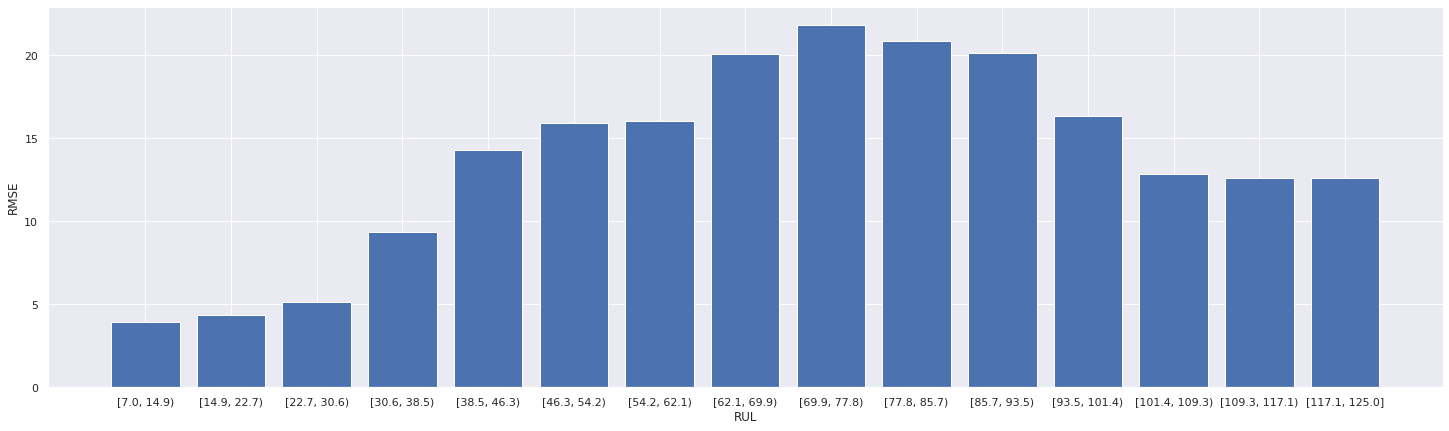

In [19]:

val_rul = np.array(true_data['RUL'])
pred_cont = np.squeeze(pred_cont)
plot_errors_wrt_RUL(val_rul, pred_cont, 125, 15, figsize=(25, 7))

# 2. Remaining useful life prediction using multi-scale deep convolutional neural network

In [20]:
from rul_pm.models.keras.MultiScaleConvolutional import MultiScaleConvolutionalModel

In [21]:

transformer = Transformer(
                'RUL',
                transformation_pipeline(                                
                    scaler=PandasTransformerWrapper(MinMaxScaler((-1, 1))),
                    features=useful_sensors
                ),
                transformerY = Pipeline(steps=[
                    ('picewise', PicewiseRULThreshold(125))
                ])
            )

TypeError: transformation_pipeline() got an unexpected keyword argument 'scaler'

In [25]:

    
def scheduler(epoch, lr): 
    if epoch < 200:
        return 0.001
    else:
        return 0.0001
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model = MultiScaleConvolutionalModel(
            3,
            (10, 15, 250),           
            10,
            window=30,
            batch_size=512,
            step = 1,
            transformer=transformer,
            shuffle='all',
            models_path=Path('.'),
            patience=15,
            cache_size=120,
            callbacks=[lr_callback],
            learning_rate=1e-3,
            loss=root_mean_squared_error)

In [26]:
model.fit(train_dataset, test_dataset, epochs=100)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 14)]     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 30, 14, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 14, 10)   110         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 14, 10)   160         lambda[0][0]                     
_____________________________________________________________________________________________

KeyboardInterrupt: 